# Dummy Classifier

This is a dummy classifier used as a baseline. It always predicts the majority class

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import random
import cv2
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as tt
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import random_split, DataLoader, Dataset

from sklearn.dummy import DummyClassifier

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

import dataloaders.nih_xray8 as nih_xray8
import dataloaders.chexpert as chexpert
import dataloaders.kaggle_rsna as kaggle_rsna

In [ ]:
# Configuration
batch_size = 64
n_workers = 4

# Strategy to use for the dummy classifier
# the 'prior' strategy will always predict the most frequent class
dummy_strategy = 'prior'

# Always use the same values as the training notebook
# otherwise we are not going to have consistent results for the comparison
# if ratio is 0.8, we are going to test using 20% of the data
# also, use always the same random seed
random_seed = 42
split_ratio = 0.8

# Define the dataset paths
DATASET1_PATH = '/bigdata/chest_xray-3'
DATASET2_PATH = '/bigdata/CheXpert-v1.0-small'
DATASET3_PATH = '/bigdata/kaggle-rsna'

In [ ]:
data1_dir = DATASET1_PATH
dataset1 = ImageFolder(data1_dir, 
                      transform=tt.Compose([tt.Resize((224, 224)),
                                            tt.ToTensor(),
                                            tt.Normalize(mean=0.482, std=0.236, inplace=True) # dataset1 mean and std
                                           ]))

In [ ]:
data2_dir = DATASET2_PATH

transform2=tt.Compose([ tt.Resize((224, 224)),
                        tt.ToTensor(),
                        tt.Normalize(mean=0.5017, std=0.2905, inplace=True) # dataset2 mean and std
                        ])

dataset2 = chexpert.CheXDataset(data2_dir, [transform2])

Loading dataset...


In [ ]:
data3_dir = DATASET3_PATH
# 


transform3=tt.Compose([ tt.ToTensor(),
                        tt.Normalize(mean=0.4841, std=0.2428, inplace=True) # dataset3 mean and std
                        ])

dataset3 = kaggle_rsna.RSNADataset(data3_dir, [transform3])

Loading dataset...


In [6]:
train_size_1 = round(len(dataset1)*split_ratio)
test_size_1 = len(dataset1) - train_size_1

train_size_2 = round(len(dataset2)*split_ratio)
test_size_2 = len(dataset2) - train_size_2

train_size_3 = round(len(dataset3)*split_ratio)
test_size_3 = len(dataset3) - train_size_3

_, test_ds1 = random_split(dataset1, [train_size_1, test_size_1])
_, test_ds2 = random_split(dataset2, [train_size_2, test_size_2])
_, test_ds3 = random_split(dataset3, [train_size_3, test_size_3])

test_dl1 = DataLoader(test_ds1, batch_size, num_workers=n_workers, pin_memory=True)
test_dl2 = DataLoader(test_ds2, batch_size, num_workers=n_workers, pin_memory=True)
test_dl3 = DataLoader(test_ds3, batch_size, num_workers=n_workers, pin_memory=True)

In [ ]:
def test_fit(test_loader):

    # Gather all test data (features and labels)
    all_features = []
    all_labels = []

    for batch in test_loader:
        features, labels = batch  # Assuming batch is a tuple (features, labels)
        all_features.append(features)
        all_labels.append(labels)

    # Concatenate all batches
    all_features = torch.cat(all_features, dim=0).numpy()  # Convert to numpy array
    all_labels = torch.cat(all_labels, dim=0).numpy()

    clf = DummyClassifier(strategy=dummy_strategy)
    clf.fit(all_features, all_labels)
    return clf

def test_predict(clf, test_loader):
    # Gather all test data (features and labels)
    all_features = []
    all_labels = []

    for batch in test_loader:
        features, labels = batch  # Assuming batch is a tuple (features, labels)
        all_features.append(features)
        all_labels.append(labels)

    # Concatenate all batches
    all_features = torch.cat(all_features, dim=0).numpy()  # Convert to numpy array
    all_labels = torch.cat(all_labels, dim=0).numpy()

    # Make random predictions
    test_preds = clf.predict(all_features)
    test_probs = clf.predict_proba(all_features)

    # Calculate accuracy (simple comparison)
    test_acc = (test_preds == all_labels).mean()

    print('test_loss: {:.4f}, test_acc: {:.4f}'.format(0.0, test_acc))  # No loss in DummyClassifier

    return test_preds, all_labels, test_probs

In [8]:
def compute_roc(outs, labels):
    scores = F.softmax(torch.tensor(outs), dim=1)[:, 1]
    scores = scores.detach().numpy()
        
    fpr, tpr, thresholds = roc_curve(labels, scores)
    
    distances = np.sqrt(fpr**2 + (1 - tpr)**2)
    best_threshold = thresholds[np.argmin(distances)]
    preds = [1 if score > best_threshold else 0 for score in scores]

    return fpr, tpr, best_threshold, preds, roc_auc_score(labels, scores)

def plot_roc(fpr, tpr, best_threshold, auroc):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auroc})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curve', fontsize=14)
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(alpha=0.3)
    plt.show()

def plot_cm(labels, preds):
    cm = confusion_matrix(labels, preds)
    plt.figure()
    plot_confusion_matrix(cm,figsize=(12,8),cmap=plt.cm.Blues)
    plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
    plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
    plt.xlabel('Predicted Label',fontsize=18)
    plt.ylabel('True Label',fontsize=18)
    plt.show()

def get_performance_metrics(cm, preds, labels):
    tn, fp, fn, tp = cm.ravel()

    accuracy = (np.array(preds) == np.array(labels)).sum() / len(preds)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2*((precision*recall)/(precision+recall))

    print("Accuracy of the model is {:.3f}".format(accuracy))
    print("Recall of the model is {:.3f}".format(recall))
    print("Precision of the model is {:.3f}".format(precision))
    print("F1 Score of the model is {:.3f}".format(f1))
    return accuracy, recall, precision, f1

# model 1

In [9]:
model = test_fit(test_dl1)

### model 1 - dataset 1

In [10]:
preds, labels, outs = test_predict(model, test_dl1)

test_loss: 0.0000, test_acc: 0.7353


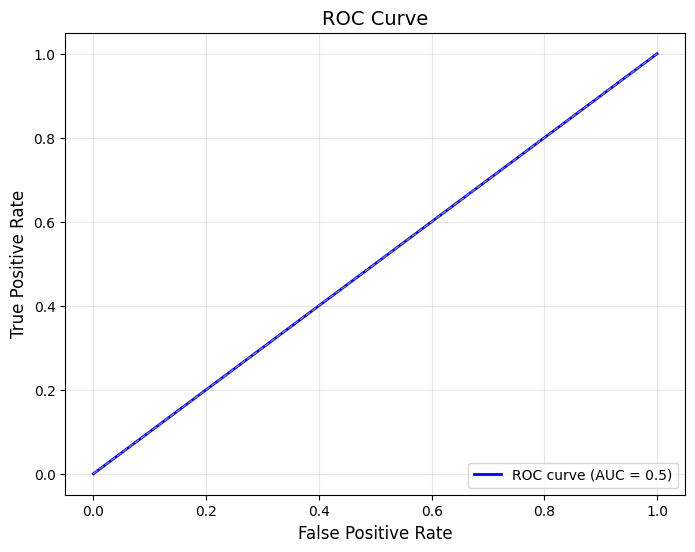

In [11]:
fpr, tpr, best_threshold, _, auroc_1_1 = compute_roc(outs, labels)
plot_roc(fpr, tpr, best_threshold, auroc_1_1)

<Figure size 640x480 with 0 Axes>

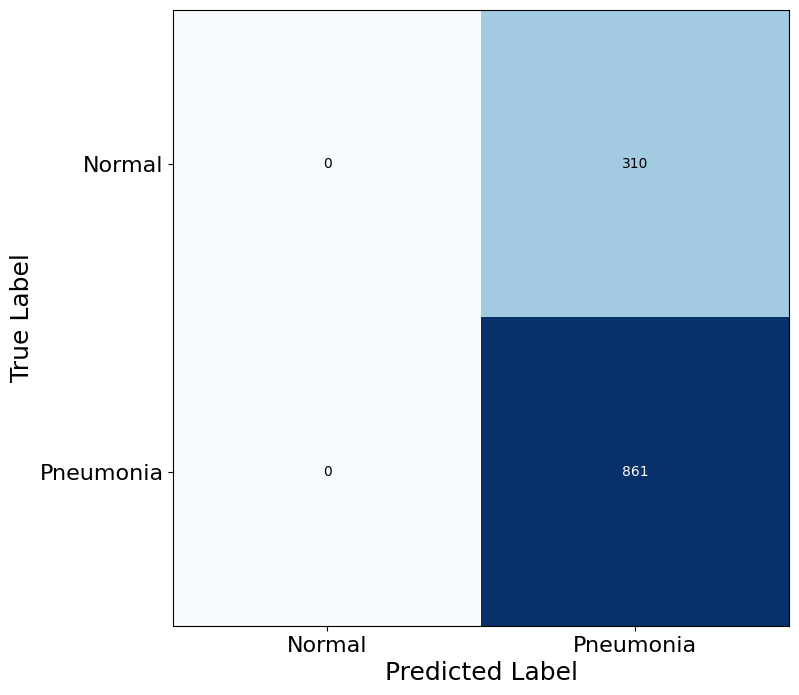

Accuracy of the model is 0.735
Recall of the model is 1.000
Precision of the model is 0.735
F1 Score of the model is 0.847


In [12]:
plot_cm(labels, preds)
accuracy_1_1, recall_1_1, precision_1_1, f1_1_1 = get_performance_metrics(confusion_matrix(labels, preds), preds, labels)

### model 1 - dataset 2

In [13]:
preds, labels, outs = test_predict(model, test_dl2)

test_loss: 0.0000, test_acc: 0.4720


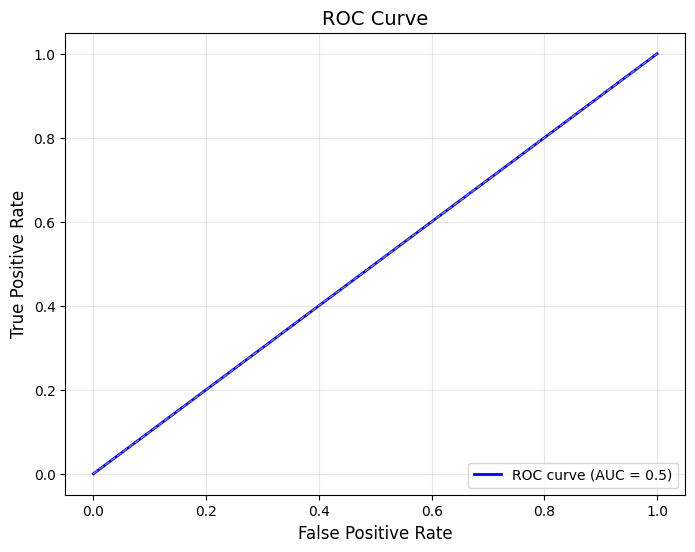

In [14]:
fpr, tpr, best_threshold, _, auroc_1_2 = compute_roc(outs, labels)
plot_roc(fpr, tpr, best_threshold, auroc_1_2)

<Figure size 640x480 with 0 Axes>

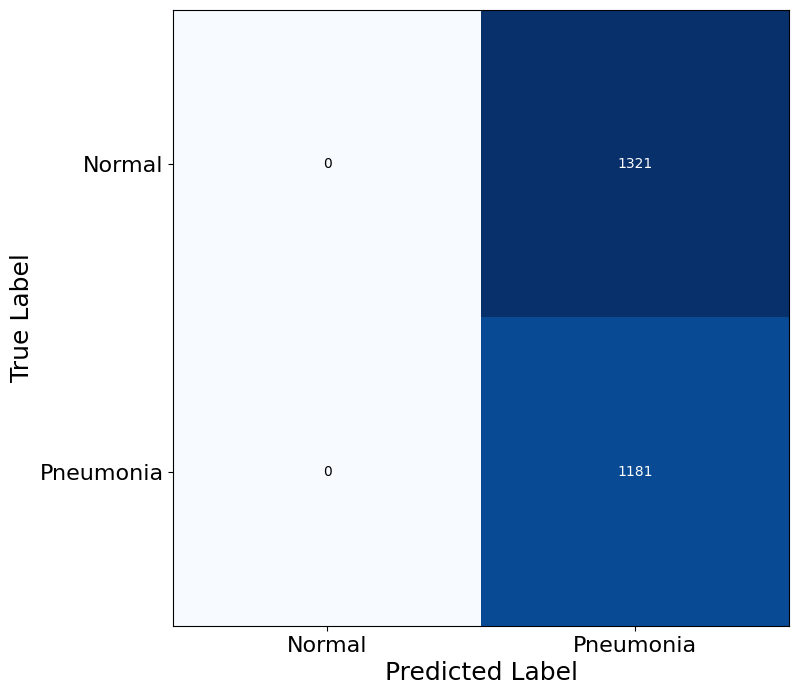

Accuracy of the model is 0.472
Recall of the model is 1.000
Precision of the model is 0.472
F1 Score of the model is 0.641


In [15]:
plot_cm(labels, preds)
accuracy_1_2, recall_1_2, precision_1_2, f1_1_2 = get_performance_metrics(confusion_matrix(labels, preds), preds, labels)

### model 1 - dataset 3

In [16]:
preds, labels, outs = test_predict(model, test_dl3)

test_loss: 0.0000, test_acc: 0.3252


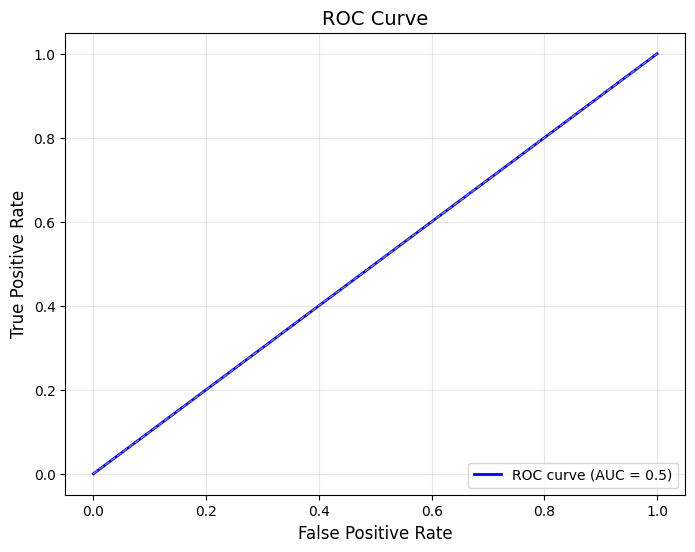

In [17]:
fpr, tpr, best_threshold, _, auroc_1_3 = compute_roc(outs, labels)
plot_roc(fpr, tpr, best_threshold, auroc_1_3)

<Figure size 640x480 with 0 Axes>

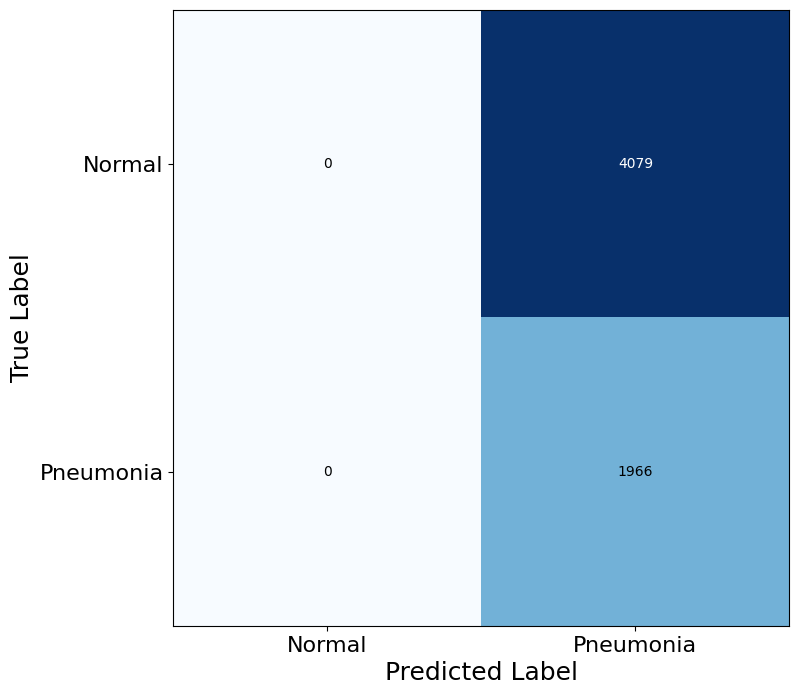

Accuracy of the model is 0.325
Recall of the model is 1.000
Precision of the model is 0.325
F1 Score of the model is 0.491


In [18]:
plot_cm(labels, preds)
accuracy_1_3, recall_1_3, precision_1_3, f1_1_3 = get_performance_metrics(confusion_matrix(labels, preds), preds, labels)

# model 2

In [19]:
model = test_fit(test_dl2)

#### model 2 - dataset 1

In [20]:
preds, labels, outs = test_predict(model, test_dl1)

test_loss: 0.0000, test_acc: 0.2647


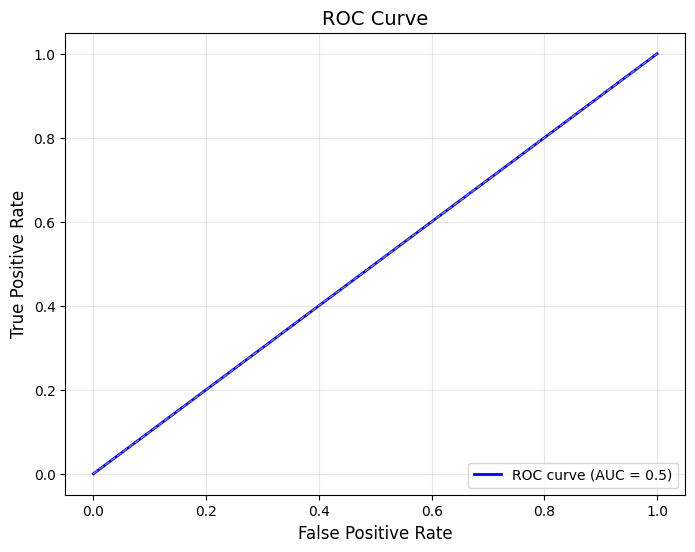

In [21]:
fpr, tpr, best_threshold, _, auroc_2_1 = compute_roc(outs, labels)
plot_roc(fpr, tpr, best_threshold, auroc_2_1)

<Figure size 640x480 with 0 Axes>

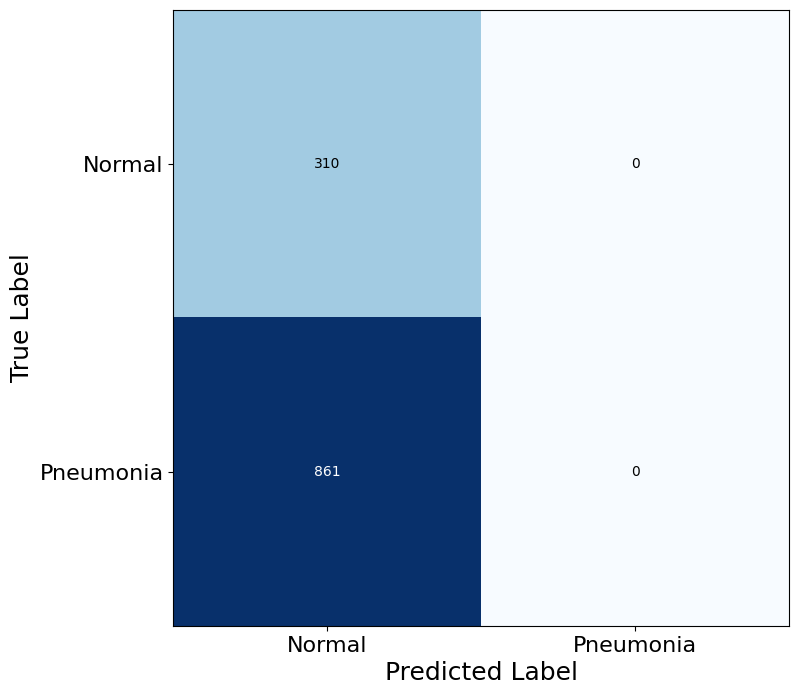

Accuracy of the model is 0.265
Recall of the model is 0.000
Precision of the model is nan
F1 Score of the model is nan


/tmp/ipykernel_831453/1635926678.py:38: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp/(tp+fp)


In [22]:
plot_cm(labels, preds)
accuracy_2_1, recall_2_1, precision_2_1, f1_2_1 = get_performance_metrics(confusion_matrix(labels, preds), preds, labels)

#### model 2 - dataset 2

In [23]:
preds, labels, outs = test_predict(model, test_dl2)

test_loss: 0.0000, test_acc: 0.5280


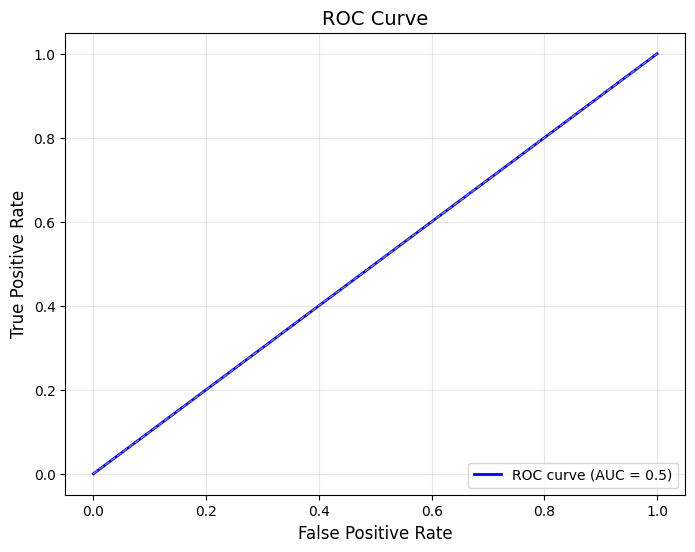

In [24]:
fpr, tpr, best_threshold, _, auroc_2_2 = compute_roc(outs, labels)
plot_roc(fpr, tpr, best_threshold, auroc_2_2)

<Figure size 640x480 with 0 Axes>

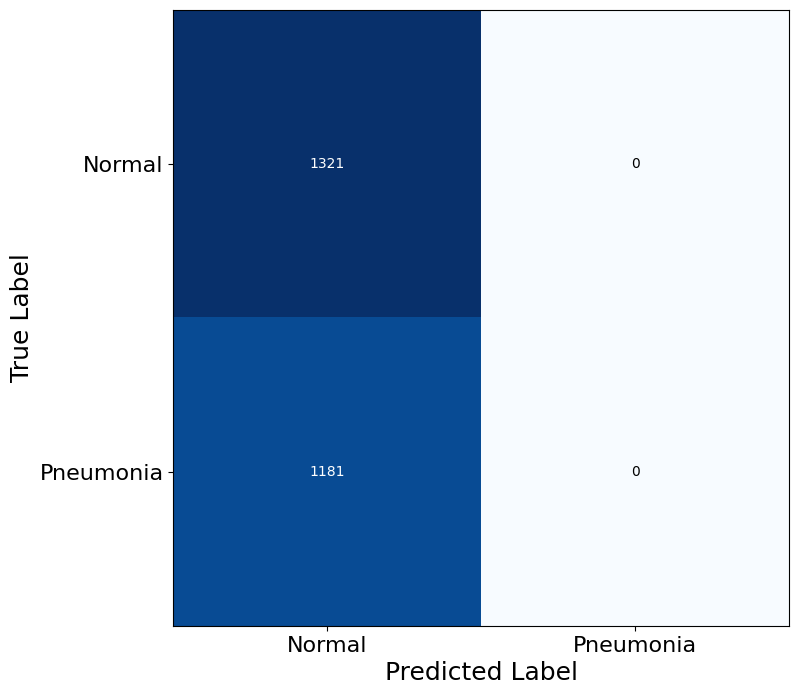

Accuracy of the model is 0.528
Recall of the model is 0.000
Precision of the model is nan
F1 Score of the model is nan


/tmp/ipykernel_831453/1635926678.py:38: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp/(tp+fp)


In [25]:
plot_cm(labels, preds)
accuracy_2_2, recall_2_2, precision_2_2, f1_2_2 = get_performance_metrics(confusion_matrix(labels, preds), preds, labels)

#### model 2 - dataset 3

In [26]:
preds, labels, outs = test_predict(model, test_dl3)

test_loss: 0.0000, test_acc: 0.6748


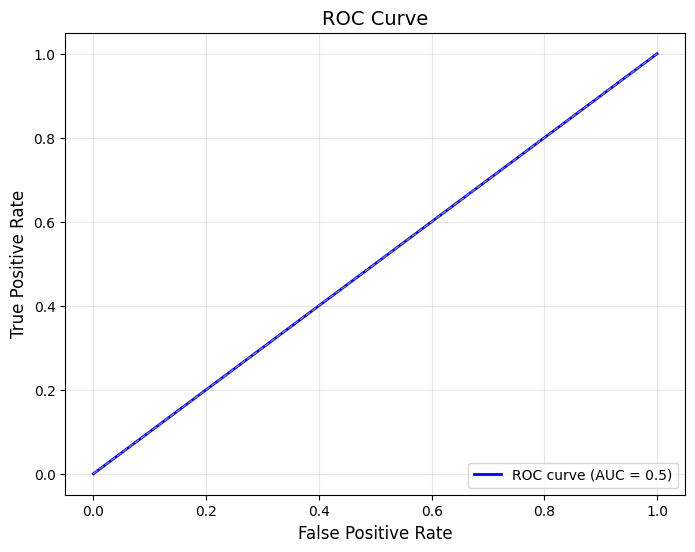

In [27]:
fpr, tpr, best_threshold, _, auroc_2_3 = compute_roc(outs, labels)
plot_roc(fpr, tpr, best_threshold, auroc_2_3)

<Figure size 640x480 with 0 Axes>

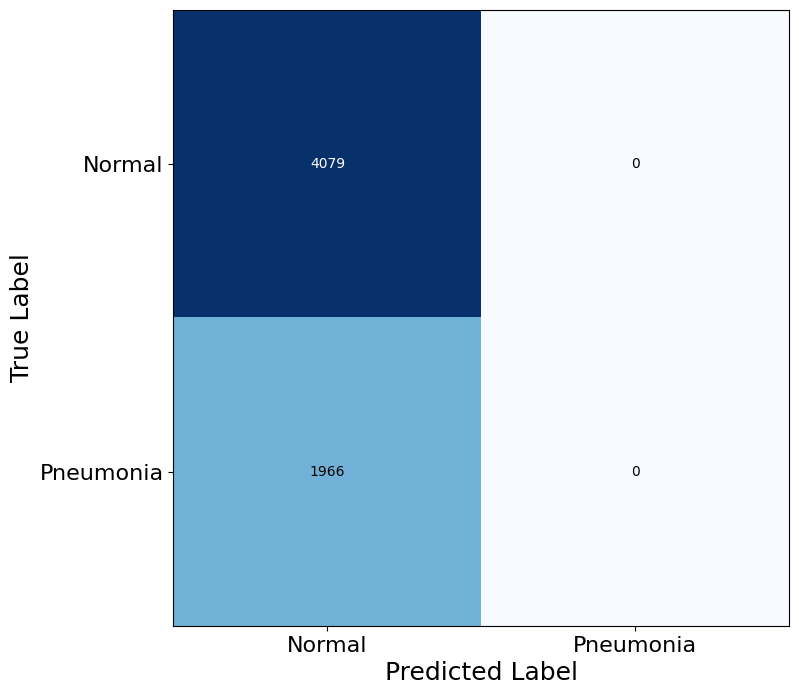

Accuracy of the model is 0.675
Recall of the model is 0.000
Precision of the model is nan
F1 Score of the model is nan


/tmp/ipykernel_831453/1635926678.py:38: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp/(tp+fp)


In [28]:
plot_cm(labels, preds)
accuracy_2_3, recall_2_3, precision_2_3, f1_2_3 = get_performance_metrics(confusion_matrix(labels, preds), preds, labels)

# model 3

#### model 3 - dataset 1

In [29]:
preds, labels, outs = test_predict(model, test_dl1)

test_loss: 0.0000, test_acc: 0.2647


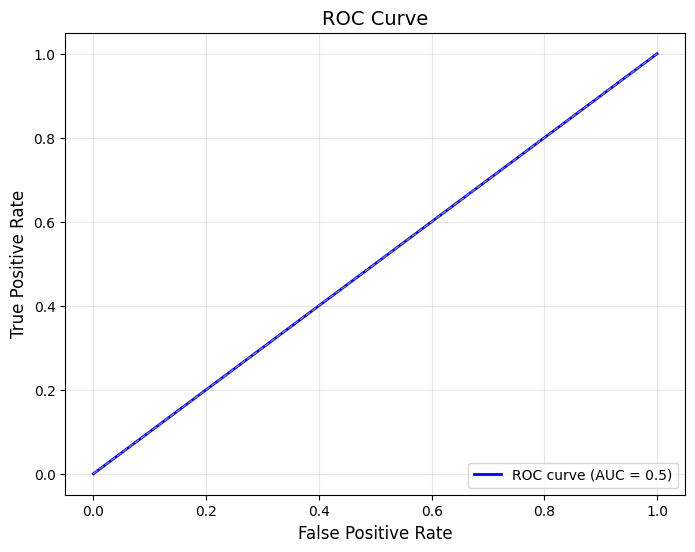

In [30]:
fpr, tpr, best_threshold, _, auroc_3_1 = compute_roc(outs, labels)
plot_roc(fpr, tpr, best_threshold, auroc_3_1)

<Figure size 640x480 with 0 Axes>

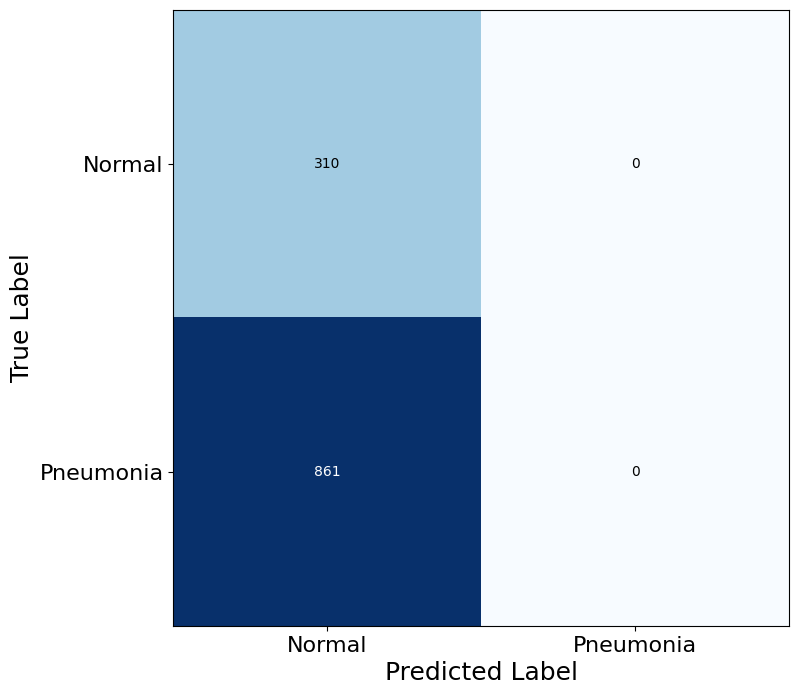

Accuracy of the model is 0.265
Recall of the model is 0.000
Precision of the model is nan
F1 Score of the model is nan


/tmp/ipykernel_831453/1635926678.py:38: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp/(tp+fp)


In [31]:
plot_cm(labels, preds)
accuracy_3_1, recall_3_1, precision_3_1, f1_3_1 = get_performance_metrics(confusion_matrix(labels, preds), preds, labels)

#### model 3 - dataset 2

In [32]:
preds, labels, outs = test_predict(model, test_dl2)

test_loss: 0.0000, test_acc: 0.5280


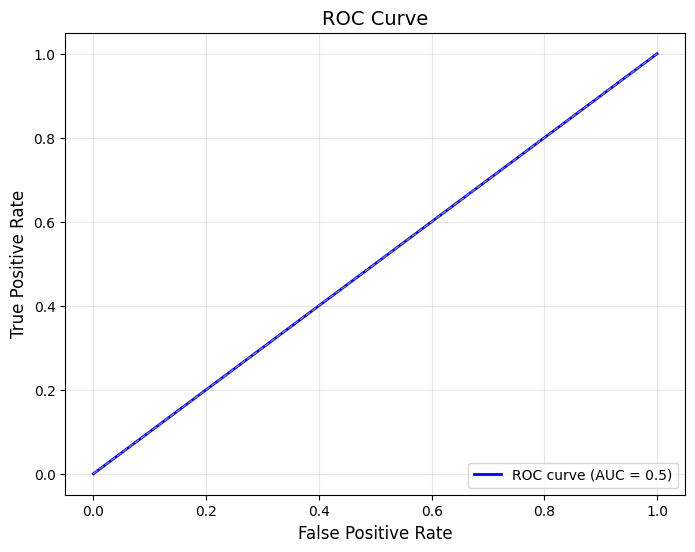

In [33]:
fpr, tpr, best_threshold, _, auroc_3_2 = compute_roc(outs, labels)
plot_roc(fpr, tpr, best_threshold, auroc_3_2)

<Figure size 640x480 with 0 Axes>

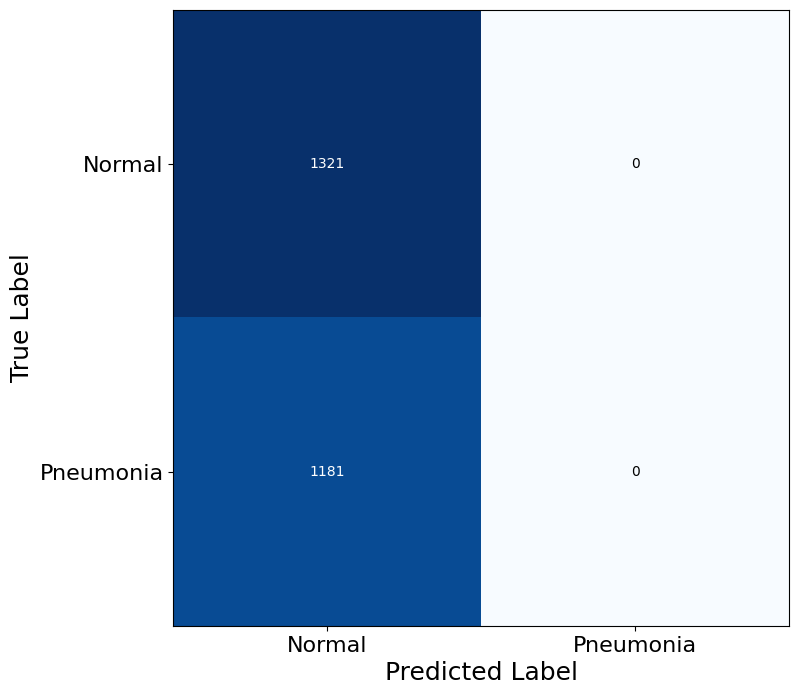

Accuracy of the model is 0.528
Recall of the model is 0.000
Precision of the model is nan
F1 Score of the model is nan


/tmp/ipykernel_831453/1635926678.py:38: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp/(tp+fp)


In [34]:
plot_cm(labels, preds)
accuracy_3_2, recall_3_2, precision_3_2, f1_3_2 = get_performance_metrics(confusion_matrix(labels, preds), preds, labels)

#### model 3 - dataset 3

In [35]:
preds, labels, outs = test_predict(model, test_dl3)

test_loss: 0.0000, test_acc: 0.6748


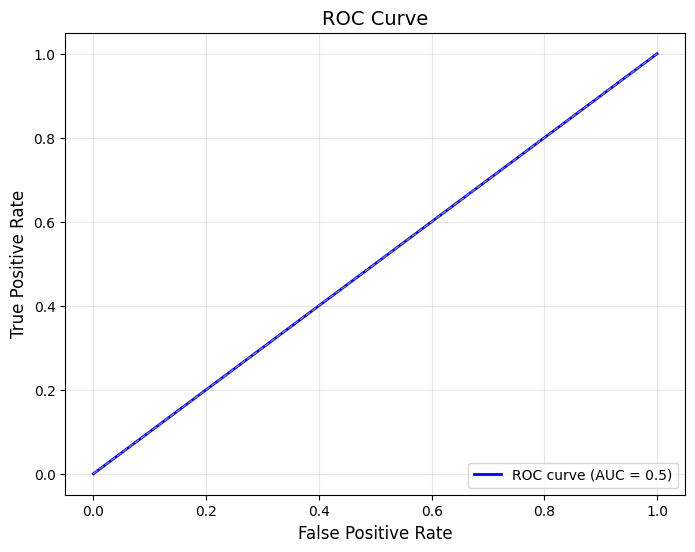

In [36]:
fpr, tpr, best_threshold, _, auroc_3_3 = compute_roc(outs, labels)
plot_roc(fpr, tpr, best_threshold, auroc_3_3)

<Figure size 640x480 with 0 Axes>

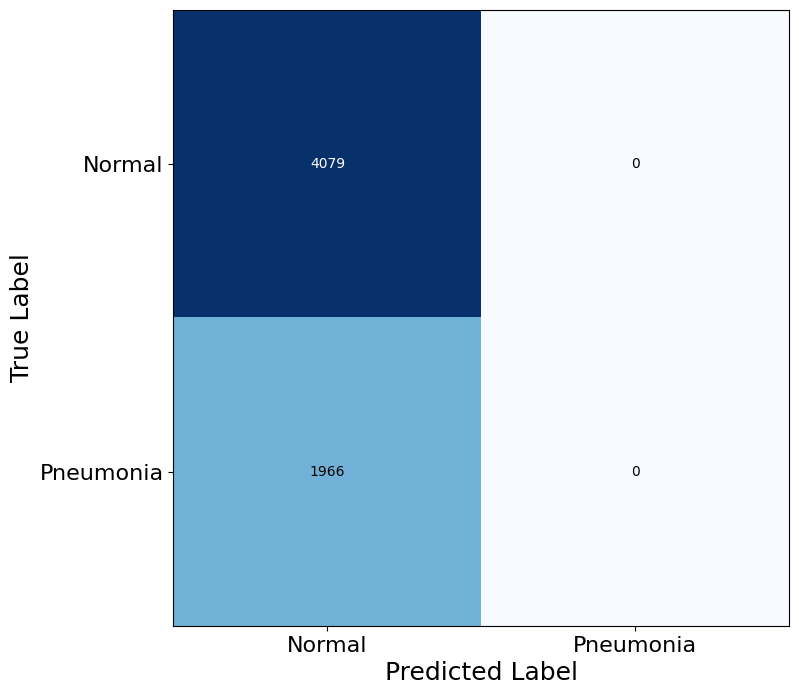

Accuracy of the model is 0.675
Recall of the model is 0.000
Precision of the model is nan
F1 Score of the model is nan


/tmp/ipykernel_831453/1635926678.py:38: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp/(tp+fp)


In [37]:
plot_cm(labels, preds)
accuracy_3_3, recall_3_3, precision_3_3, f1_3_3 = get_performance_metrics(confusion_matrix(labels, preds), preds, labels)

# Plot the charts

In [38]:
from matplotlib import colors
def plot_graph(name, data, center):
    plt.figure(figsize=(4, 3))
    divnorm=colors.TwoSlopeNorm(vmin=.5, vcenter=center, vmax=1)
    heatmap = plt.imshow(data, cmap="coolwarm_r", aspect="auto", norm=divnorm)
    
    cbar = plt.colorbar(heatmap)
    cbar.set_label(name)
    
    plt.xticks(ticks=[0, 1, 2], labels=["CXr", "CheX", "RSNA"])
    plt.yticks(ticks=[0, 1, 2], labels=["CXr", "CheX", "RSNA"])
    
    for (i, j), val in np.ndenumerate(data):
        plt.text(j, i, f"{val:.2f}", ha='center', va='center', color='white')
    
    plt.title(name)
    
    plt.tight_layout()
    plt.show()

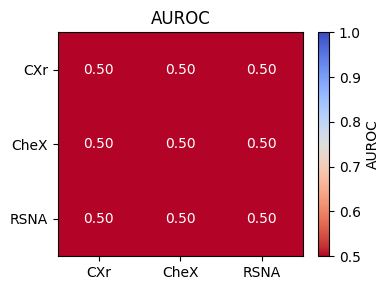

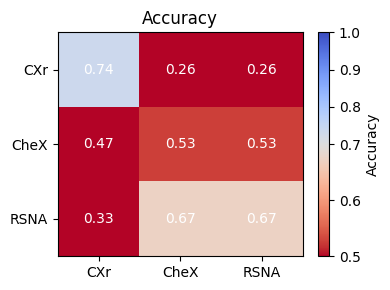

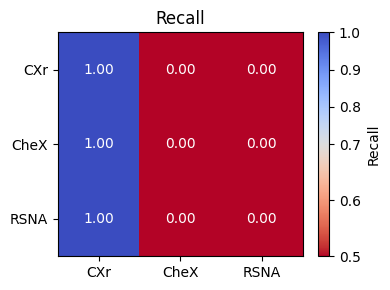

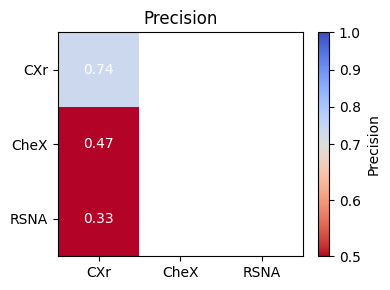

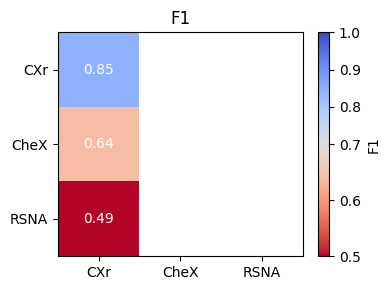

In [39]:
data = np.array([[auroc_1_1, auroc_1_2, auroc_1_3], [auroc_2_1, auroc_2_2, auroc_2_3], [auroc_3_1, auroc_3_2, auroc_3_3]]).transpose()
plot_graph("AUROC", data, 0.75)

data = np.array([[accuracy_1_1, accuracy_1_2, accuracy_1_3], [accuracy_2_1, accuracy_2_2, accuracy_2_3], [accuracy_3_1, accuracy_3_2, accuracy_3_3]]).transpose()
plot_graph("Accuracy", data, 0.7)

data = np.array([[recall_1_1, recall_1_2, recall_1_3], [recall_2_1, recall_2_2, recall_2_3], [recall_3_1, recall_3_2, recall_3_3]]).transpose()
plot_graph("Recall", data, 0.7)

data = np.array([[precision_1_1, precision_1_2, precision_1_3], [precision_2_1, precision_2_2, precision_2_3], [precision_3_1, precision_3_2, precision_3_3]]).transpose()
plot_graph("Precision", data, 0.7)

data = np.array([[f1_1_1, f1_1_2, f1_1_3], [f1_2_1, f1_2_2, f1_2_3], [f1_3_1, f1_3_2, f1_3_3]]).transpose()
plot_graph("F1", data, 0.7)

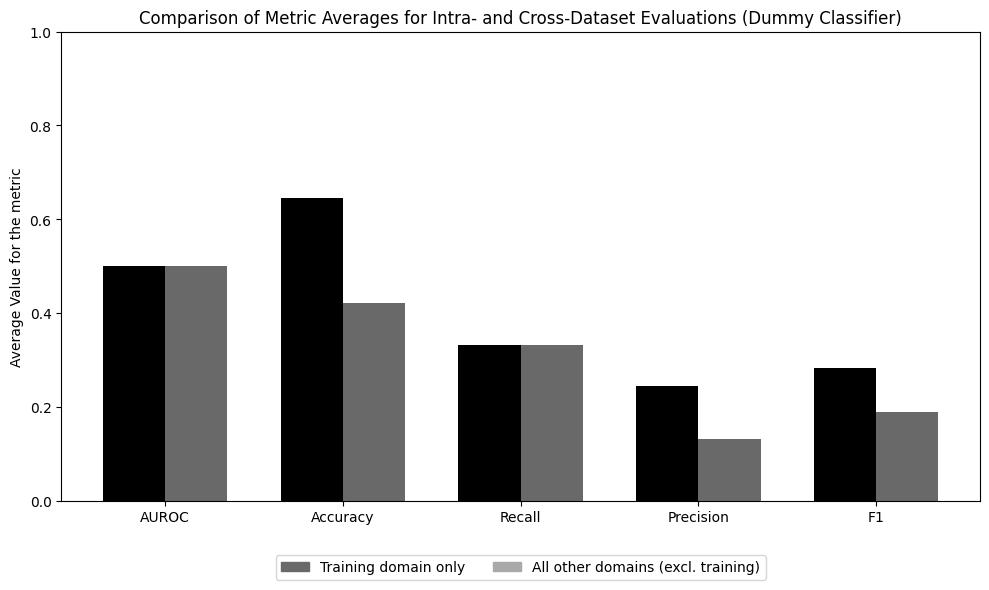

In [40]:
# Dati delle metriche
auroc = np.array([[auroc_1_1, auroc_1_2, auroc_1_3],
                  [auroc_2_1, auroc_2_2, auroc_2_3],
                  [auroc_3_1, auroc_3_2, auroc_3_3]])

accuracy = np.array([[accuracy_1_1, accuracy_1_2, accuracy_1_3],
                     [accuracy_2_1, accuracy_2_2, accuracy_2_3],
                     [accuracy_3_1, accuracy_3_2, accuracy_3_3]])

recall = np.array([[recall_1_1, recall_1_2, recall_1_3],
                   [recall_2_1, recall_2_2, recall_2_3],
                   [recall_3_1, recall_3_2, recall_3_3]])

precision = np.array([[precision_1_1, precision_1_2, precision_1_3],
                      [precision_2_1, precision_2_2, precision_2_3],
                      [precision_3_1, precision_3_2, precision_3_3]])

f1 = np.array([[f1_1_1, f1_1_2, f1_1_3],
               [f1_2_1, f1_2_2, f1_2_3],
               [f1_3_1, f1_3_2, f1_3_3]])

# Convert NaN values to 0 to avoid numerical issues
auroc = np.nan_to_num(auroc, nan=0.0)
accuracy = np.nan_to_num(accuracy, nan=0.0)
recall = np.nan_to_num(recall, nan=0.0)
precision = np.nan_to_num(precision, nan=0.0)
f1 = np.nan_to_num(f1, nan=0.0)

# Funzione per calcolare le medie
def calculate_means(metric_data):
    same_dataset = np.diagonal(metric_data)
    different_dataset = metric_data[~np.eye(metric_data.shape[0], dtype=bool)]
    return np.mean(same_dataset), np.mean(different_dataset)

# Calcolo delle medie per ogni metrica
metrics = ["AUROC", "Accuracy", "Recall", "Precision", "F1"]
values_same = []
values_different = []

for metric_data in [auroc, accuracy, recall, precision, f1]:
    mean_same, mean_different = calculate_means(metric_data)
    values_same.append(mean_same)
    values_different.append(mean_different)

# Colori distinti per ogni metrica
colors_same = ['black', 'black', 'black', 'black', 'black']
colors_different = ['dimgrey', 'dimgrey', 'dimgrey', 'dimgrey', 'dimgrey']

# Plottaggio
x = np.arange(len(metrics))  # Posizioni sulle x per le metriche
width = 0.35  # Larghezza delle barre

fig, ax = plt.subplots(figsize=(10, 6))

# Disegna le barre
for i in range(len(metrics)):
    ax.bar(x[i] - width/2, values_same[i], width, color=colors_same[i], label="Stesso Dataset" if i == 0 else None)
    ax.bar(x[i] + width/2, values_different[i], width, color=colors_different[i], label="Dataset Diversi" if i == 0 else None)

# Configurazioni del grafico
#ax.set_xlabel("")
ax.set_ylabel("Average Value for the metric")
ax.set_title("Comparison of Metric Averages for Intra- and Cross-Dataset Evaluations (Dummy Classifier)")
ax.set_xticks(x)
ax.set_xticklabels(metrics)

# Aggiungi legenda con label personalizzate in grigio
legend_labels = ["Training domain only", "All other domains (excl. training)"]
legend_colors = ['dimgrey', 'darkgrey']
custom_handles = [plt.Rectangle((0, 0), 1, 1, color=legend_colors[i]) for i in range(len(legend_labels))]
ax.legend(custom_handles, legend_labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

# Mostra il grafico
plt.ylim(0, 1)  # Adatta in base all'intervallo delle metriche
plt.tight_layout()
plt.show()
